### Experimentation to Improve Base Model Performance

In [1]:
import os

import shutil
import keras
import random
import keras_cv
import warnings
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score
from keras.utils import image_dataset_from_directory

2024-12-09 20:04:39.030401: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 20:04:41.451360: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 20:04:54.372402: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


In [2]:
warnings.filterwarnings("ignore")

In [3]:
# Reproducability
tf.keras.utils.set_random_seed(69)

In [4]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Define paths
train_dir = 'waste-images/train'  # Update this path
val_dir = 'waste-images/val'      # Update this path
test_dir = 'waste-images/test'    # Update this path
base_model_path = 'waste_classification_model.h5'  # Path to your base model

# Define parameters
image_size = (64, 64)
batch_size = 32
num_classes = 3
epochs = 20

# Load the base model
base_model = load_model(base_model_path)

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Visualization Function
def plot_history(history, experiment_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{experiment_name}: Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{experiment_name}: Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def evaluate_model(model, experiment_name):
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"{experiment_name} - Test Accuracy: {test_accuracy}")
    print(f"{experiment_name} - Test Loss: {test_loss}")

    # Confusion Matrix and Classification Report
    test_labels = test_generator.classes
    predictions = model.predict(test_generator)
    predicted_classes = predictions.argmax(axis=1)

    conf_matrix = confusion_matrix(test_labels, predicted_classes)
    print(f"{experiment_name} - Confusion Matrix:")
    print(conf_matrix)

    report = classification_report(test_labels, predicted_classes, target_names=list(test_generator.class_indices.keys()))
    print(f"{experiment_name} - Classification Report:")
    print(report)

# -------------------- EXPERIMENT 1: Baseline Evaluation --------------------
print("Evaluating Baseline Model...")
evaluate_model(base_model, "Baseline Model")

Found 9801 images belonging to 3 classes.
Found 2800 images belonging to 3 classes.
Found 1400 images belonging to 3 classes.
Evaluating Baseline Model...
44/44 [==============================] - 24s 522ms/step - loss: 0.6727 - accuracy: 0.7229
Baseline Model - Test Accuracy: 0.7228571176528931
Baseline Model - Test Loss: 0.6726542711257935
44/44 [==============================] - 3s 69ms/step
Baseline Model - Confusion Matrix:
[[130  59   5]
 [ 29 696  49]
 [ 25 221 186]]
Baseline Model - Classification Report:
               precision    recall  f1-score   support

   Food Waste       0.71      0.67      0.69       194
Mixed Recycle       0.71      0.90      0.80       774
        Trash       0.78      0.43      0.55       432

     accuracy                           0.72      1400
    macro avg       0.73      0.67      0.68      1400
 weighted avg       0.73      0.72      0.71      1400



In [7]:
def build_model(dropout_rate=0.5, learning_rate=0.001):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(*image_size, 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate + 0.1),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate + 0.2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate + 0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Experiment 2: Hyperparameter Tuning
Training model with dropout=0.3 and learning_rate=0.001
Epoch 1/20
307/307 [==============================] - 44s 139ms/step - loss: 1.1053 - accuracy: 0.5498 - val_loss: 1.5590 - val_accuracy: 0.3507
Epoch 2/20
307/307 [==============================] - 42s 137ms/step - loss: 0.9083 - accuracy: 0.5680 - val_loss: 0.9631 - val_accuracy: 0.5461
Epoch 3/20
307/307 [==============================] - 39s 127ms/step - loss: 0.8808 - accuracy: 0.5818 - val_loss: 0.8549 - val_accuracy: 0.5611
Epoch 4/20
307/307 [==============================] - 39s 127ms/step - loss: 0.8773 - accuracy: 0.5853 - val_loss: 1.0521 - val_accuracy: 0.5950
Epoch 5/20
307/307 [==============================] - 39s 126ms/step - loss: 0.8718 - accuracy: 0.5861 - val_loss: 0.8194 - val_accuracy: 0.6218
Epoch 6/20
307/307 [==============================] - 39s 128ms/step - loss: 0.8618 - accuracy: 0.5937 - val_loss: 0.7925 - val_accuracy: 0.6411
Epoch 7/20
307/307 [==================

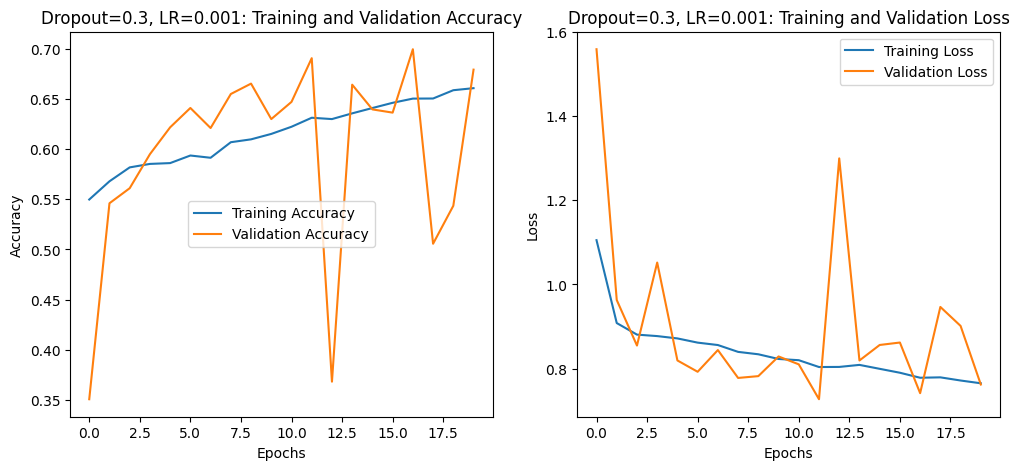

Validation accuracy: 0.6996428370475769
Training model with dropout=0.3 and learning_rate=0.0005
Epoch 1/20
307/307 [==============================] - 40s 126ms/step - loss: 1.1019 - accuracy: 0.5301 - val_loss: 2.2525 - val_accuracy: 0.4796
Epoch 2/20
307/307 [==============================] - 39s 128ms/step - loss: 0.9201 - accuracy: 0.5732 - val_loss: 1.4663 - val_accuracy: 0.5289
Epoch 3/20
307/307 [==============================] - 39s 128ms/step - loss: 0.8964 - accuracy: 0.5749 - val_loss: 1.0164 - val_accuracy: 0.6046
Epoch 4/20
307/307 [==============================] - 37s 122ms/step - loss: 0.8854 - accuracy: 0.5855 - val_loss: 0.9154 - val_accuracy: 0.6021
Epoch 5/20
307/307 [==============================] - 37s 121ms/step - loss: 0.8785 - accuracy: 0.5851 - val_loss: 0.9765 - val_accuracy: 0.6043
Epoch 6/20
307/307 [==============================] - 37s 122ms/step - loss: 0.8594 - accuracy: 0.5938 - val_loss: 0.8061 - val_accuracy: 0.6275
Epoch 7/20
307/307 [=============

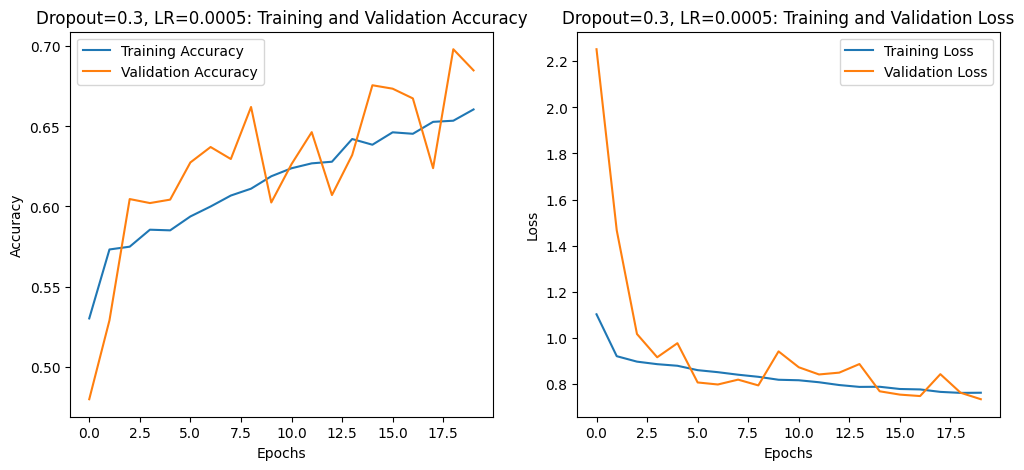

Validation accuracy: 0.6982142925262451
Training model with dropout=0.3 and learning_rate=0.0001
Epoch 1/20
307/307 [==============================] - 40s 128ms/step - loss: 1.3493 - accuracy: 0.4899 - val_loss: 1.9851 - val_accuracy: 0.2782
Epoch 2/20
307/307 [==============================] - 38s 122ms/step - loss: 0.9657 - accuracy: 0.5436 - val_loss: 1.1268 - val_accuracy: 0.5239
Epoch 3/20
307/307 [==============================] - 38s 123ms/step - loss: 0.9263 - accuracy: 0.5637 - val_loss: 1.0367 - val_accuracy: 0.5696
Epoch 4/20
307/307 [==============================] - 37s 122ms/step - loss: 0.9146 - accuracy: 0.5647 - val_loss: 0.9662 - val_accuracy: 0.5821
Epoch 5/20
307/307 [==============================] - 37s 122ms/step - loss: 0.8959 - accuracy: 0.5752 - val_loss: 0.9592 - val_accuracy: 0.5868
Epoch 6/20
307/307 [==============================] - 38s 123ms/step - loss: 0.8874 - accuracy: 0.5752 - val_loss: 0.9472 - val_accuracy: 0.6000
Epoch 7/20
307/307 [=============

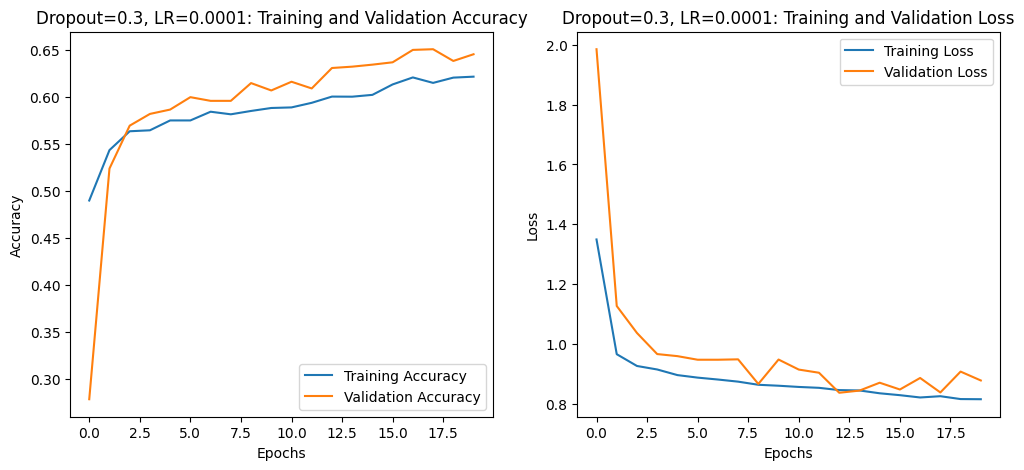

Validation accuracy: 0.6510714292526245
Training model with dropout=0.4 and learning_rate=0.001
Epoch 1/20
307/307 [==============================] - 41s 131ms/step - loss: 1.1268 - accuracy: 0.5362 - val_loss: 1.6373 - val_accuracy: 0.5893
Epoch 2/20
307/307 [==============================] - 41s 132ms/step - loss: 0.9288 - accuracy: 0.5658 - val_loss: 0.9461 - val_accuracy: 0.5807
Epoch 3/20
307/307 [==============================] - 41s 132ms/step - loss: 0.9120 - accuracy: 0.5656 - val_loss: 1.1210 - val_accuracy: 0.5468
Epoch 4/20
307/307 [==============================] - 40s 130ms/step - loss: 0.9083 - accuracy: 0.5700 - val_loss: 0.8604 - val_accuracy: 0.6050
Epoch 5/20
307/307 [==============================] - 40s 130ms/step - loss: 0.9052 - accuracy: 0.5654 - val_loss: 0.8327 - val_accuracy: 0.6161
Epoch 6/20
307/307 [==============================] - 40s 130ms/step - loss: 0.8997 - accuracy: 0.5697 - val_loss: 0.8674 - val_accuracy: 0.5668
Epoch 7/20
307/307 [==============

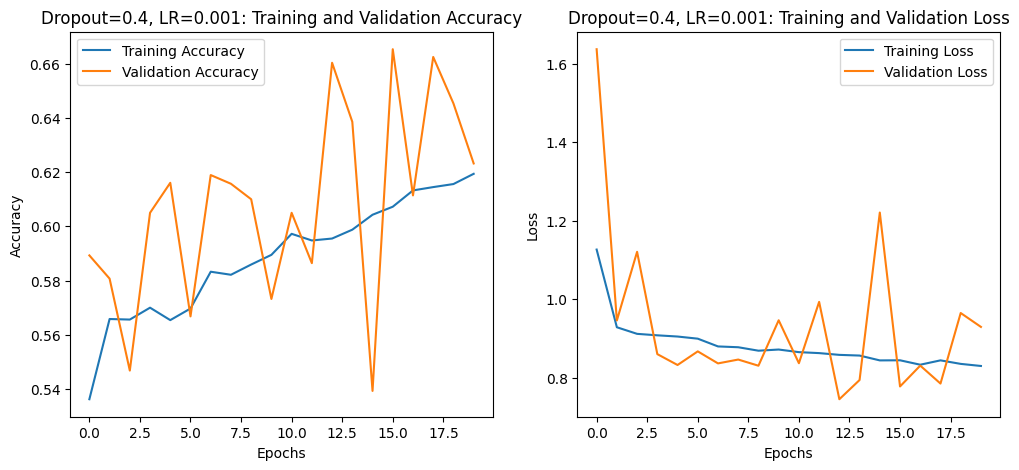

Validation accuracy: 0.6653571724891663
Training model with dropout=0.4 and learning_rate=0.0005
Epoch 1/20
307/307 [==============================] - 39s 122ms/step - loss: 1.1603 - accuracy: 0.5264 - val_loss: 2.4630 - val_accuracy: 0.3743
Epoch 2/20
307/307 [==============================] - 37s 121ms/step - loss: 0.9248 - accuracy: 0.5581 - val_loss: 1.4023 - val_accuracy: 0.5386
Epoch 3/20
307/307 [==============================] - 38s 124ms/step - loss: 0.9097 - accuracy: 0.5649 - val_loss: 0.8885 - val_accuracy: 0.5857
Epoch 4/20
307/307 [==============================] - 38s 124ms/step - loss: 0.9019 - accuracy: 0.5720 - val_loss: 0.9389 - val_accuracy: 0.5793
Epoch 5/20
307/307 [==============================] - 37s 119ms/step - loss: 0.8926 - accuracy: 0.5718 - val_loss: 1.1860 - val_accuracy: 0.5964
Epoch 6/20
307/307 [==============================] - 38s 123ms/step - loss: 0.8831 - accuracy: 0.5795 - val_loss: 0.9934 - val_accuracy: 0.5961
Epoch 7/20
307/307 [=============

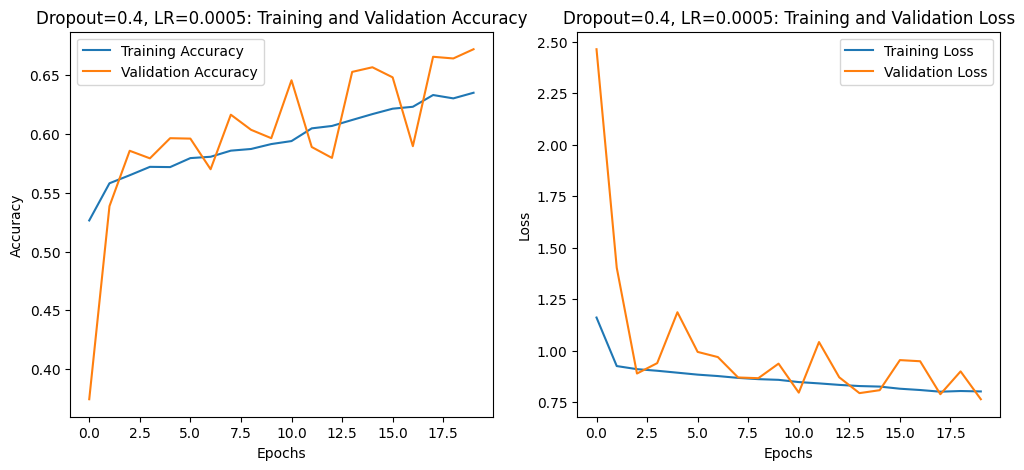

Validation accuracy: 0.6721428632736206
Training model with dropout=0.4 and learning_rate=0.0001
Epoch 1/20
307/307 [==============================] - 39s 124ms/step - loss: 1.6004 - accuracy: 0.4637 - val_loss: 3.5962 - val_accuracy: 0.2639
Epoch 2/20
307/307 [==============================] - 39s 126ms/step - loss: 1.0095 - accuracy: 0.5361 - val_loss: 1.5705 - val_accuracy: 0.4364
Epoch 3/20
307/307 [==============================] - 39s 125ms/step - loss: 0.9656 - accuracy: 0.5484 - val_loss: 1.4192 - val_accuracy: 0.4975
Epoch 4/20
307/307 [==============================] - 39s 126ms/step - loss: 0.9411 - accuracy: 0.5550 - val_loss: 1.1905 - val_accuracy: 0.5482
Epoch 5/20
307/307 [==============================] - 39s 126ms/step - loss: 0.9286 - accuracy: 0.5614 - val_loss: 1.2232 - val_accuracy: 0.5471
Epoch 6/20
307/307 [==============================] - 38s 122ms/step - loss: 0.9137 - accuracy: 0.5706 - val_loss: 1.1752 - val_accuracy: 0.5543
Epoch 7/20
307/307 [=============

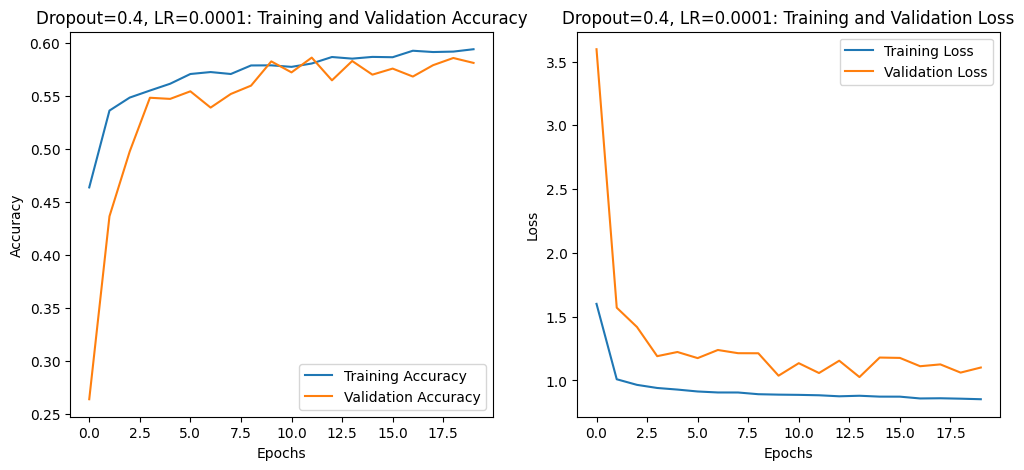

Validation accuracy: 0.5860714316368103
Training model with dropout=0.5 and learning_rate=0.001
Epoch 1/20
307/307 [==============================] - 39s 125ms/step - loss: 1.2740 - accuracy: 0.5299 - val_loss: 1.5048 - val_accuracy: 0.3857
Epoch 2/20
307/307 [==============================] - 38s 125ms/step - loss: 0.9562 - accuracy: 0.5616 - val_loss: 2.4234 - val_accuracy: 0.3100
Epoch 3/20
307/307 [==============================] - 37s 119ms/step - loss: 0.9366 - accuracy: 0.5648 - val_loss: 1.3371 - val_accuracy: 0.4629
Epoch 4/20
307/307 [==============================] - 36s 118ms/step - loss: 0.9317 - accuracy: 0.5643 - val_loss: 1.1573 - val_accuracy: 0.5904
Epoch 5/20
307/307 [==============================] - 39s 129ms/step - loss: 0.9267 - accuracy: 0.5656 - val_loss: 0.9490 - val_accuracy: 0.5739
Epoch 6/20
307/307 [==============================] - 40s 129ms/step - loss: 0.9239 - accuracy: 0.5645 - val_loss: 0.9120 - val_accuracy: 0.5607
Epoch 7/20
307/307 [==============

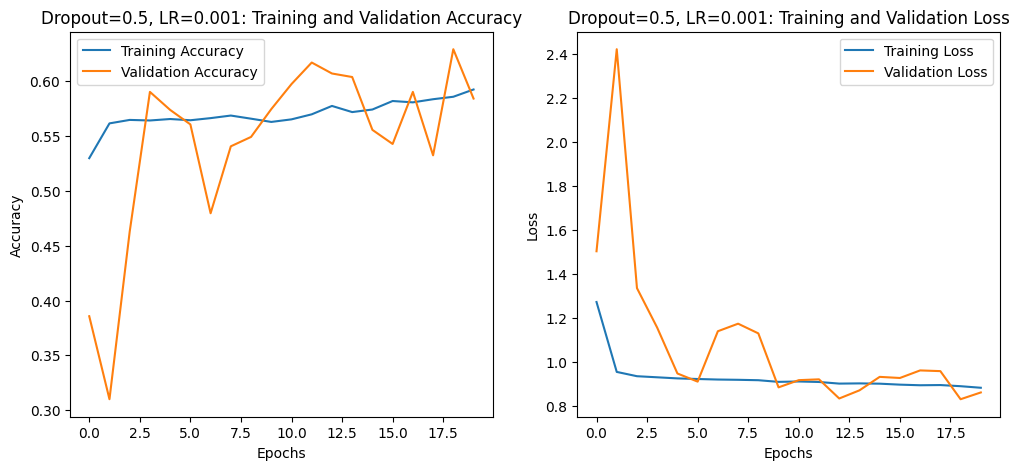

Validation accuracy: 0.6292856931686401
Training model with dropout=0.5 and learning_rate=0.0005
Epoch 1/20
307/307 [==============================] - 41s 131ms/step - loss: 1.3557 - accuracy: 0.5180 - val_loss: 2.0037 - val_accuracy: 0.5089
Epoch 2/20
 22/307 [=>............................] - ETA: 30s - loss: 0.9610 - accuracy: 0.5639

In [ ]:
# -------------------- EXPERIMENT 2: Hyperparameter Tuning --------------------
print("Experiment 2: Hyperparameter Tuning")
dropout_rates = [0.3, 0.4, 0.5]
learning_rates = [0.001, 0.0005, 0.0001]

best_model = None
best_val_accuracy = 0

for dropout_rate in dropout_rates:
    for lr in learning_rates:
        print(f"Training model with dropout={dropout_rate} and learning_rate={lr}")
        model = build_model(dropout_rate=dropout_rate, learning_rate=lr)
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=epochs,
            verbose=1
        )
        plot_history(history, f"Dropout={dropout_rate}, LR={lr}")
        val_accuracy = max(history.history['val_accuracy'])
        print(f"Validation accuracy: {val_accuracy}")
        
        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model
            model.save('best_model.h5')

evaluate_model(best_model, "Best Hyperparameter Tuned Model")

Experiment 3: Data Augmentation
Found 9801 images belonging to 3 classes.
Epoch 1/20
307/307 [==============================] - 251s 813ms/step - loss: 1.1879 - accuracy: 0.5283 - val_loss: 3.5256 - val_accuracy: 0.1589
Epoch 2/20
307/307 [==============================] - 49s 158ms/step - loss: 0.9276 - accuracy: 0.5691 - val_loss: 2.0168 - val_accuracy: 0.3389
Epoch 3/20
307/307 [==============================] - 47s 154ms/step - loss: 0.9053 - accuracy: 0.5721 - val_loss: 0.9557 - val_accuracy: 0.5757
Epoch 4/20
307/307 [==============================] - 47s 154ms/step - loss: 0.8890 - accuracy: 0.5796 - val_loss: 0.9471 - val_accuracy: 0.5700
Epoch 5/20
307/307 [==============================] - 48s 155ms/step - loss: 0.8681 - accuracy: 0.5855 - val_loss: 1.1045 - val_accuracy: 0.5625
Epoch 6/20
307/307 [==============================] - 47s 155ms/step - loss: 0.8641 - accuracy: 0.5860 - val_loss: 0.9440 - val_accuracy: 0.5475
Epoch 7/20
307/307 [==============================] - 4

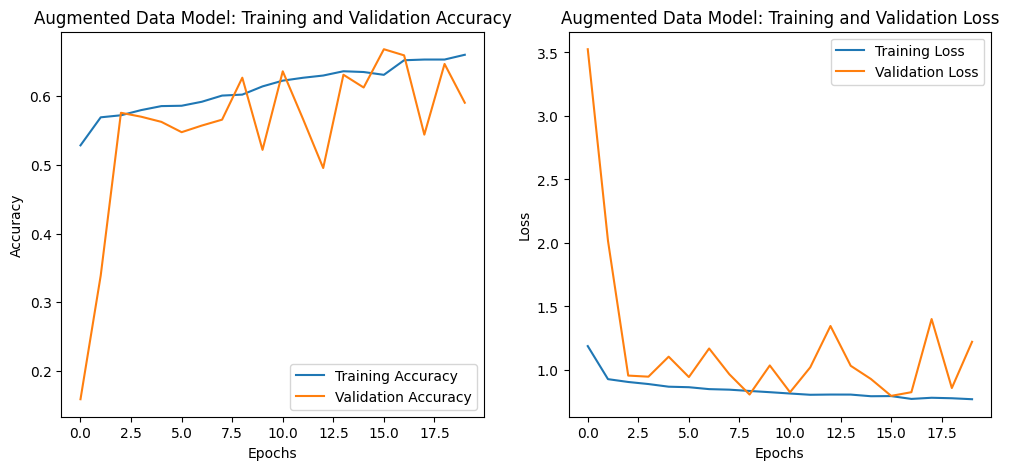

44/44 [==============================] - 4s 80ms/step - loss: 1.2127 - accuracy: 0.5764
Augmented Data Model - Test Accuracy: 0.5764285922050476
Augmented Data Model - Test Loss: 1.2126953601837158
44/44 [==============================] - 3s 70ms/step
Augmented Data Model - Confusion Matrix:
[[169  12  13]
 [209 431 134]
 [107 118 207]]
Augmented Data Model - Classification Report:
               precision    recall  f1-score   support

   Food Waste       0.35      0.87      0.50       194
Mixed Recycle       0.77      0.56      0.65       774
        Trash       0.58      0.48      0.53       432

     accuracy                           0.58      1400
    macro avg       0.57      0.64      0.56      1400
 weighted avg       0.65      0.58      0.59      1400



In [8]:
# -------------------- EXPERIMENT 3: Data Augmentation --------------------
print("Experiment 3: Data Augmentation")
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,       # Slightly reduce rotations
    width_shift_range=0.1,   # Limit shifts
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]  # Realistic lighting variations
)

train_generator_augmented = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

model_augmented = build_model(dropout_rate=0.4, learning_rate=0.0005)
history_augmented = model_augmented.fit(
    train_generator_augmented,
    validation_data=val_generator,
    epochs=epochs,
    verbose=1
)
plot_history(history_augmented, "Augmented Data Model")
evaluate_model(model_augmented, "Augmented Data Model")

Experiment 4: Adding Extra Convolutional Layers
Epoch 1/20
307/307 [==============================] - 48s 151ms/step - loss: 1.1522 - accuracy: 0.5222 - val_loss: 1.5347 - val_accuracy: 0.3489
Epoch 2/20
307/307 [==============================] - 44s 142ms/step - loss: 0.9017 - accuracy: 0.5700 - val_loss: 1.3327 - val_accuracy: 0.5593
Epoch 3/20
307/307 [==============================] - 43s 141ms/step - loss: 0.8739 - accuracy: 0.5789 - val_loss: 1.1907 - val_accuracy: 0.5707
Epoch 4/20
307/307 [==============================] - 43s 140ms/step - loss: 0.8587 - accuracy: 0.5903 - val_loss: 1.2166 - val_accuracy: 0.5368
Epoch 5/20
307/307 [==============================] - 43s 141ms/step - loss: 0.8440 - accuracy: 0.5968 - val_loss: 2.9796 - val_accuracy: 0.3007
Epoch 6/20
307/307 [==============================] - 43s 141ms/step - loss: 0.8313 - accuracy: 0.5998 - val_loss: 1.0761 - val_accuracy: 0.5850
Epoch 7/20
307/307 [==============================] - 44s 143ms/step - loss: 0.816

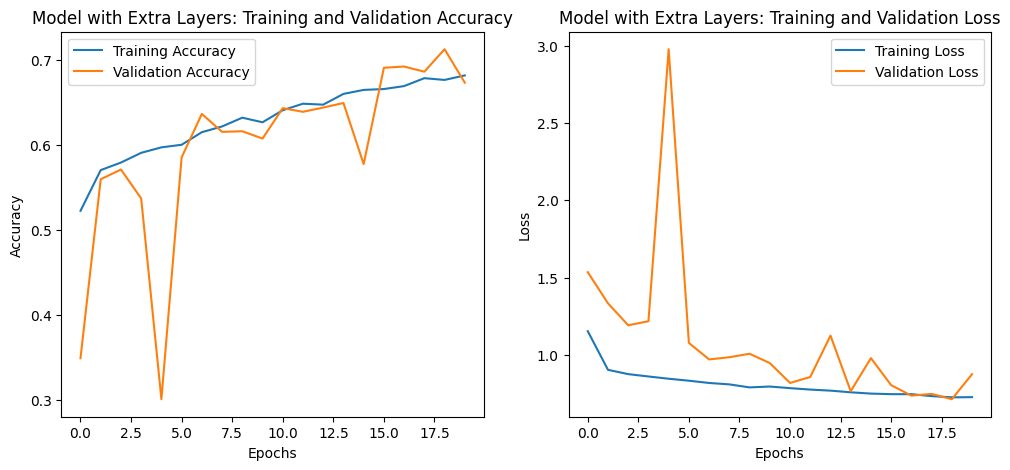

44/44 [==============================] - 4s 83ms/step - loss: 0.9662 - accuracy: 0.6293
Model with Extra Layers - Test Accuracy: 0.6292856931686401
Model with Extra Layers - Test Loss: 0.966227650642395
44/44 [==============================] - 3s 70ms/step
Model with Extra Layers - Confusion Matrix:
[[135  56   3]
 [ 78 668  28]
 [ 60 294  78]]
Model with Extra Layers - Classification Report:
               precision    recall  f1-score   support

   Food Waste       0.49      0.70      0.58       194
Mixed Recycle       0.66      0.86      0.75       774
        Trash       0.72      0.18      0.29       432

     accuracy                           0.63      1400
    macro avg       0.62      0.58      0.54      1400
 weighted avg       0.65      0.63      0.58      1400



In [9]:
# -------------------- EXPERIMENT 4: Adding Extra Layers --------------------
print("Experiment 4: Adding Extra Convolutional Layers")

def build_model_with_extra_layers(dropout_rate=0.4, learning_rate=0.0005):
    model = Sequential([
        # First set of convolutional layers
        Conv2D(32, (3, 3), activation='relu', input_shape=(*image_size, 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),

        # Adding additional convolutional layer
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),

        Conv2D(256, (3, 3), activation='relu'),  # Extra layer
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),

        # Fully connected layers
        Flatten(),
        Dense(256, activation='relu'),  # Increased units
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_extra_layers = build_model_with_extra_layers()
history_extra_layers = model_extra_layers.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    verbose=1
)
plot_history(history_extra_layers, "Model with Extra Layers")
evaluate_model(model_extra_layers, "Model with Extra Layers")

In [ ]:
# -------------------- EXPERIMENT 5: Increasing Dense Layers --------------------
print("Experiment 5: Adding Extra Dense Layers")

def build_model_with_dense_layers(dropout_rate=0.4, learning_rate=0.0005):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(*image_size, 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),

        # Fully connected layers
        Flatten(),
        Dense(256, activation='relu'),  # Increased units
        Dropout(dropout_rate),
        Dense(128, activation='relu'),  # Extra dense layer
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_dense_layers = build_model_with_dense_layers()
history_dense_layers = model_dense_layers.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    verbose=1
)
plot_history(history_dense_layers, "Model with Extra Dense Layers")
evaluate_model(model_dense_layers, "Model with Extra Dense Layers")